In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [55]:
# Cargar datos
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

In [56]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['administracion'], random_state=81418)

In [57]:
# Contar la cantidad de clases en el conjunto de entrenamiento
train_class_counts = train_df['administracion'].value_counts()
print("Distribución de clases en el conjunto de entrenamiento:")
print(train_class_counts)

# Contar la cantidad de clases en el conjunto de prueba
test_class_counts = test_df['administracion'].value_counts()
print("\nDistribución de clases en el conjunto de prueba:")
print(test_class_counts)


Distribución de clases en el conjunto de entrenamiento:
administracion
0    34
1    34
2    29
3    11
4    10
5    10
Name: count, dtype: int64

Distribución de clases en el conjunto de prueba:
administracion
1    15
0    15
2    13
5     5
4     4
3     4
Name: count, dtype: int64


## ENTRETAMIENTO

In [58]:
train_df

,textos,administracion
127,retsevmo en monoterapia está indicado para el...,2
141,cáncer de mama talzenna está indicadoen monot...,2
21,carvykti está indicado para el tratamiento de...,3
130,rozlytrek en monoterapia está indicado para e...,0
113,opdualag está indicado para el tratamiento de...,1
...,...,...
167,micosis fungoides (fases avanzada .,0
161,carcinoma de mama que no responde a la cirugí...,3
147,cáncer de mama triple negativo (cmt tecentriq...,1
81,cáncer colorrectal lonsurf está indicadoen co...,3


In [59]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords

# Descargar stopwords en español de nltk
nltk.download('stopwords')

spanish_stopwords = stopwords.words('spanish')

# Inicializar el vectorizador TF-IDF con las stopwords en español
vectorizer0 = TfidfVectorizer(stop_words=spanish_stopwords, ngram_range=(1, 2))


segunda_linea = [
    "han recibido tratamiento previo",
    "han tenido terapia antes",
    "han sido tratados previamente",
    "han recibido medicación antes",
    "han tenido tratamiento médico previo",
    'Con tratamiento previo',
    'un tratamiento sistémico previo',
    'han sido previamente tratados',
    'al menos, un tratamiento sistémico',
    'al menos, un tratamiento',
    'han recibido terapia sistémica previa',
    'al menos una terapia previa',
    'han recibido quimioterapia previa',
    'al menos, un régimen de quimioterapia',
    'han recibido al menos un tratamiento previo',
    'al menos un tratamiento previo',
    'segunda línea',
    'cuya enfermedad no haya presentado progresión después de',
    'hayan sido tratados previamente'
]

primera_linea = [
    "no han recibido tratamiento previo",
    "no han tenido terapia antes",
    "no han sido tratados previamente",
    "no han recibido medicación antes",
    "no han tenido tratamiento médico previo",
    'sin tratamiento previo',
    'no han recibido quimioterapia previamente',
    'no tratados previamente',
    'en primera remisión tratados',
    'no han sido previamente tratados',
    'primera línea'
]

tercena_linea = [
    'han recibido al menos tres tratamientos previos',
    'después de al menos dos tratamientos previos',
    'al menos tres tratamientos previos',
    'tercera línea',
]

textos = train_df['textos']

# Función para dividir el texto con una ventana deslizante
def dividir_texto(texto, tamaño_ventana):
    palabras = texto.split()
    fragmentos = [' '.join(palabras[i:i+tamaño_ventana]) for i in range(len(palabras) - tamaño_ventana + 1)]
    return fragmentos

# Listas para almacenar los resultados finales
resultados_similitud = []
resultados_linea = []
resultados_frag = []
connotaciones_iguales = []

# Calcular representaciones numéricas de las líneas de referencia
vectorizer0.fit(primera_linea + segunda_linea + tercena_linea)
embeddings1 = vectorizer0.transform(primera_linea).toarray()
embeddings2 = vectorizer0.transform(segunda_linea).toarray()
embeddings3 = vectorizer0.transform(tercena_linea).toarray()

porcentaje = []
window = [4, 5, 6, 7]

for texto_largo in textos:
    for h in window:
        porcentaje = (h-1)/h
        fragmentos = dividir_texto(texto_largo, h)
    
        similitud = []
        linea = []
        frag = []
    
        for fragmento in fragmentos:
            embedding_fragmento = vectorizer0.transform([fragmento]).toarray()
    
            # Calcular similitudes con primera_linea
            similarities1 = cosine_similarity(embedding_fragmento, embeddings1)
            for idx_i, sentence1 in enumerate(primera_linea):
                similarity_score = similarities1[0][idx_i]
                if similarity_score > porcentaje:
                    similitud.append(similarity_score)
                    linea.append("primera_linea")
                    frag.append(fragmento)
    
            # Calcular similitudes con segunda_linea
            similarities2 = cosine_similarity(embedding_fragmento, embeddings2)
            for idx_i, sentence2 in enumerate(segunda_linea):
                similarity_score = similarities2[0][idx_i]
                if similarity_score > porcentaje:
                    similitud.append(similarity_score)
                    linea.append("segunda_linea")
                    frag.append(fragmento)
    
            # Calcular similitudes con tercera_linea
            similarities3 = cosine_similarity(embedding_fragmento, embeddings3)
            for idx_i, sentence3 in enumerate(tercena_linea):
                similarity_score = similarities3[0][idx_i]
                if similarity_score > porcentaje:
                    similitud.append(similarity_score)
                    linea.append("tercena_linea")
                    frag.append(fragmento)
    
    # Crear un DataFrame temporal con los resultados del texto actual
    df_temp = pd.DataFrame({
        'similitud': similitud,
        'linea': linea,
        'frag': frag
    })

    # Seleccionar la fila con la similitud más alta para cada tipo de línea
    df_max_similitud_por_linea = df_temp.loc[df_temp.groupby('linea')['similitud'].idxmax()]

    # Guardar los resultados en las listas finales
    resultados_similitud.append(df_max_similitud_por_linea['similitud'].tolist())
    resultados_linea.append(df_max_similitud_por_linea['linea'].tolist())
    resultados_frag.append(df_max_similitud_por_linea['frag'].tolist())

# Crear un DataFrame final con los resultados
df_final = pd.DataFrame({
    'textos': textos,
    'frag': resultados_frag,
    'similitud': resultados_similitud,
    'linea': resultados_linea
})

df_final['label_real'] = df['administracion']
df_final

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lazkuenaru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,textos,frag,similitud,linea,label_real
127,retsevmo en monoterapia está indicado para el...,[tras tratamiento previo con sorafenib y/o len...,"[1.0000000000000002, 1.0000000000000002]","[primera_linea, segunda_linea]",2
141,cáncer de mama talzenna está indicadoen monot...,[los pacientes deben haber sido tratados previ...,"[1.0, 1.0]","[primera_linea, segunda_linea]",2
21,carvykti está indicado para el tratamiento de...,[han recibido al menos tres tratamientos previ...,[1.0],[tercena_linea],3
130,rozlytrek en monoterapia está indicado para e...,[],[],[],0
113,opdualag está indicado para el tratamiento de...,[de primera línea del melanoma avanzado (irres...,[1.0],[primera_linea],1
...,...,...,...,...,...
167,micosis fungoides (fases avanzada .,[],[],[],0
161,carcinoma de mama que no responde a la cirugí...,[],[],[],3
147,cáncer de mama triple negativo (cmt tecentriq...,[y que no hayan recibido quimioterapia previa],[1.0],[segunda_linea],1
81,cáncer colorrectal lonsurf está indicadoen co...,[],[],[],3


In [60]:
# Total de valores en la columna
total_valores = len(df_final['linea'])

# Total de valores que son iguales a []
valores_vacios = df_final['linea'].apply(lambda x: x != []).sum()

print(f"Total de valores en la columna: {total_valores}")
print(f"Total de valores que son iguales a []: {valores_vacios}")

Total de valores en la columna: 128
Total de valores que son iguales a []: 63


In [61]:
def obtener_label_pred(lin):
    if lin == ['tercena_linea']:
        return 3
    elif lin == ['primera_linea', 'segunda_linea'] :
        return 4
    elif lin == ['primera_linea']:
        return 1
    elif lin == ['segunda_linea']:
        return 2
    elif lin == ['segunda_linea', 'tercena_linea'] or ['primera_linea', 'tercena_linea']:
        return 5
    else:
        return 0

In [62]:
df = df_final[df_final['linea'].apply(lambda x: x != [])]
df = df[['linea','label_real']]

In [63]:
# Aplicar la función a cada fila de 'linea'
df['label_pred'] = df['linea'].apply(obtener_label_pred)

In [64]:
import numpy as np
np.unique(df['label_real'])


array([0, 1, 2, 3, 4, 5], dtype=int64)


Accuracy: 0.6190476190476191

Recall: 0.6190476190476191

F1-score: 0.616235827664399


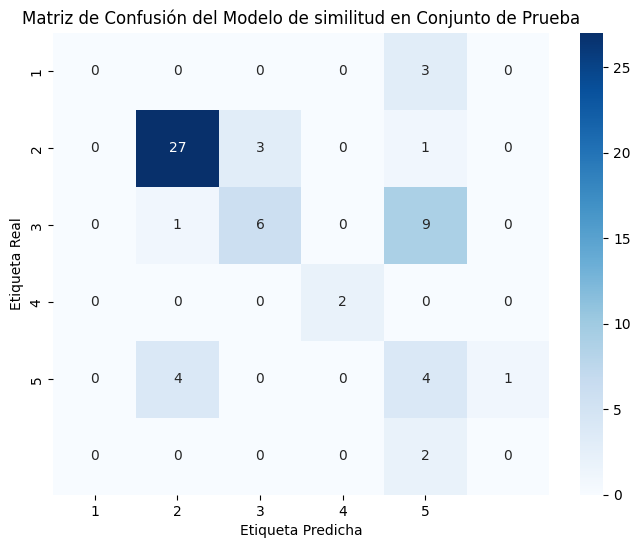

In [65]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, confusion_matrix

# Calcular métricas de clasificación
accuracy = accuracy_score(df['label_real'], df['label_pred'])
recall = recall_score(df['label_real'], df['label_pred'], average='weighted', zero_division=0)
f1 = f1_score(df['label_real'], df['label_pred'], average='weighted', zero_division=0)
conf_matrix = confusion_matrix(df['label_real'], df['label_pred'])

# Mostrar resultados
print("\nAccuracy:", accuracy)
print("\nRecall:", recall)
print("\nF1-score:", f1)

# Matriz de Confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(df['label_real'], df['label_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i+1) for i in range(5)], yticklabels=[str(i+1) for i in range(5)])
plt.title("Matriz de Confusión del Modelo de similitud en Conjunto de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [6]:
# Guardar vectorizador y listas de referencia
vectorizer_path = r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\modelos\vectorizer0_similitud.joblib'
listas_referencia = {
    "primera_linea": primera_linea,
    "segunda_linea": segunda_linea,
    "tercena_linea": tercena_linea
}

joblib.dump((vectorizer0, listas_referencia), vectorizer_path)

['C:\\Users\\lazkuenaru\\Desktop\\TFM\\pharmaceutical_extraction\\src\\Model\\modelos\\vectorizer0_similitud.joblib']

In [7]:
df_final['label_pred'] = None
for i, lin in enumerate(df_final['linea']):
    
    if lin == ['tercena_linea']:
        df_final['label_pred'][i] = 3
        
    elif lin == ['primera_linea', 'segunda_linea']:
        df_final['label_pred'][i] = 4
        
    elif lin == ['primera_linea']:
        df_final['label_pred'][i] = 1
        
    elif lin == ['segunda_linea']:
        df_final['label_pred'][i] = 2
        
    elif lin == ['segunda_linea','tercena_linea']:
        df_final['label_pred'][i] = 5
        
    elif lin == ['primera_linea','tercena_linea']:
         df_final['label_pred'][i] = 6
    else:
        df_final['label_pred'][i] = 0

C:\Users\lazkuenaru\AppData\Local\Temp\ipykernel_10112\2329082538.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_final['label_pred'][i] = 4
C:\Users\lazkuenaru\AppData\Local\Temp\ipykernel_10112\2329082538.py:8: SettingWithCopyWarnin

In [8]:
# DataFrame con todas las filas donde label_pred es 0
df_label_0 = df_final[df_final['label_pred'] == 0]

# DataFrame con todas las filas donde label_pred es diferente de 0
df_label_non_0 = df_final[df_final['label_pred'] != 0]

In [9]:
df_label_0 = df_label_0[['textos','label_real']]

C:\Users\lazkuenaru\anaconda3\envs\nlp\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Reporte de clasificación para la primera clasificación:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         9
           4       0.00      0.00      0.00         2
           5       1.00      0.33      0.50         6

    accuracy                           0.65        17
   macro avg       0.55      0.44      0.43        17
weighted avg       0.69      0.65      0.59        17



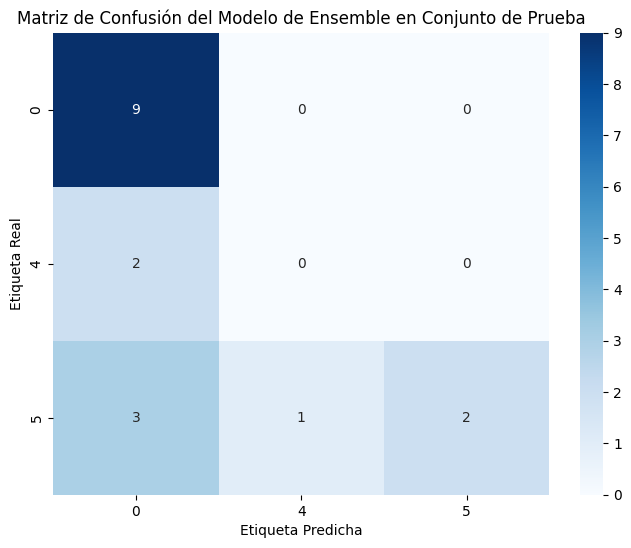

C:\Users\lazkuenaru\anaconda3\envs\nlp\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Reporte de clasificación para la primera clasificación:
              precision    recall  f1-score   support

           0       0.68      0.76      0.72        17
           1       0.50      0.60      0.55        10
           2       0.71      0.56      0.62         9
           3       1.00      0.33      0.50         3

    accuracy                           0.64        39
   macro avg       0.72      0.56      0.60        39
weighted avg       0.67      0.64      0.64        39



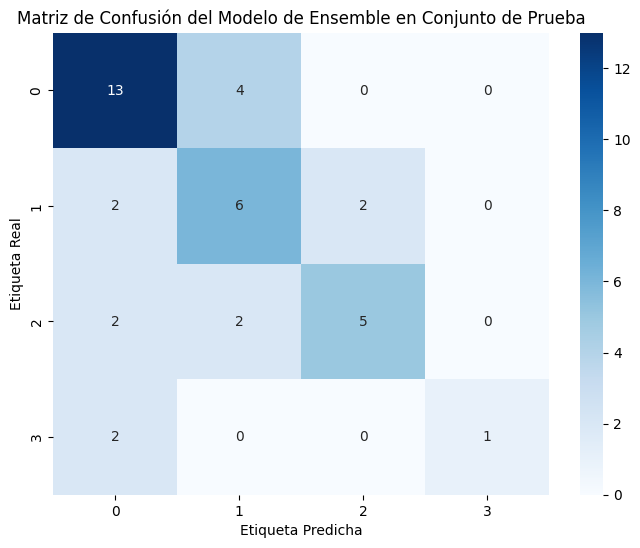

In [27]:
## Model 2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo los datos con clases 0, 4, y 5
df_filtered = train_df[train_df['administracion'].isin([0, 4, 5])]

# Asumimos que 'textos' es la columna de frases y 'administracion' es la columna de clase
X = df_filtered['textos']  # Frases
y = df_filtered['administracion']  # Clases originales

# Dividir los datos en conjuntos de entrenamiento y prueba para la primera clasificación
random = 81418
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y, test_size=0.3, random_state=random)

# Vectorización de texto usando TF-IDF
vectorizer2 = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer2.fit_transform(X_train_main)
X_test_tfidf = vectorizer2.transform(X_test_main)

# Crear el modelo de ensemble
gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=10, random_state=81418)
rf = RandomForestClassifier(n_estimators=150, random_state=81418)
ada = AdaBoostClassifier(random_state=81418)
et = ExtraTreesClassifier(n_estimators=150, random_state=81418)
lr = LogisticRegression(random_state=81418, max_iter=200)

segundo_ensemble_model = VotingClassifier(
    estimators=[
         ('rf', rf),
        ('gb', gb),
        ('et', et),
        ('lr', lr),
        ('ada', ada)
    ],
    voting='soft'
)

# Entrenar el modelo en el conjunto filtrado de entrenamiento
segundo_ensemble_model.fit(X_train_tfidf, y_train_main)

# Predicciones y evaluación del primer modelo
y_pred_main = segundo_ensemble_model.predict(X_test_tfidf)
print("Reporte de clasificación para la primera clasificación:")
print(classification_report(y_test_main, y_pred_main))

# Matriz de Confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test_main, y_pred_main)

# Etiquetas únicas reales
labels = [0, 4, 5]

# Graficar la matriz de confusión con etiquetas correctas
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión del Modelo de Ensemble en Conjunto de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()


## Model 1
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np


# Asumimos que 'textos' es la columna de frases y 'administracion' es la columna de clase
X = train_df['textos']  # Frases
y = train_df['administracion']  # Clases originales

# Convertir clases 4 y 5 a 'no linea'
y_main = y.replace({4: 0, 5: 0})  # Cambiar las clases 4 y 5 a 0 ('no linea')

# Dividir los datos en conjuntos de entrenamiento y prueba para la primera clasificación
random = 81418
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y_main, test_size=0.3, random_state=random, stratify=y_main)

# Vectorización de texto usando TF-IDF
vectorizer1 = TfidfVectorizer(max_features=5000)  # Puedes ajustar max_features según sea necesario
X_train_tfidf = vectorizer1.fit_transform(X_train_main)
X_test_tfidf = vectorizer1.transform(X_test_main)

# Crear los clasificadores
gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=10, random_state=81418)
rf = RandomForestClassifier(n_estimators=150, random_state=81418)
ada = AdaBoostClassifier(random_state=81418)
et = ExtraTreesClassifier(n_estimators=150, random_state=81418)
lr = LogisticRegression(random_state=81418, max_iter=200)

primer_ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('et', et),
        ('lr', lr),
        ('ada', ada)
    ],
    voting='soft'  # 'soft' utiliza las probabilidades, 'hard' usa la mayoría de votos
)

primer_ensemble_model.fit(X_train_tfidf, y_train_main)

# Predicciones y evaluación del primer modelo
y_pred_main = primer_ensemble_model.predict(X_test_tfidf)
print("Reporte de clasificación para la primera clasificación:")
print(classification_report(y_test_main, y_pred_main))

# Matriz de Confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test_main, y_pred_main)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(4)], yticklabels=[str(i) for i in range(4)])
plt.title("Matriz de Confusión del Modelo de Ensemble en Conjunto de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()


In [11]:
## Model 2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo los datos con clases 0, 4, y 5
df_filtered = train_df[train_df['administracion'].isin([0, 4, 5])]

# Asumimos que 'textos' es la columna de frases y 'administracion' es la columna de clase
X = df_filtered['textos']  # Frases
y = df_filtered['administracion']  # Clases originales

# Dividir los datos en conjuntos de entrenamiento y prueba para la primera clasificación
random = 81418
X_train_main = X
y_train_main = y

# Vectorización de texto usando TF-IDF
vectorizer2 = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer2.fit_transform(X_train_main)
X_test_tfidf = vectorizer2.transform(X_test_main)

# Crear el modelo de ensemble
gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=10, random_state=81418)
rf = RandomForestClassifier(n_estimators=150, random_state=81418)
ada = AdaBoostClassifier(random_state=81418)
et = ExtraTreesClassifier(n_estimators=150, random_state=81418)
lr = LogisticRegression(random_state=81418, max_iter=200)

segundo_ensemble_model = VotingClassifier(
    estimators=[
         ('rf', rf),
        ('gb', gb),
        ('et', et),
        ('lr', lr),
        ('ada', ada)
    ],
    voting='soft'
)

# Entrenar el modelo en el conjunto filtrado de entrenamiento
segundo_ensemble_model.fit(X_train_tfidf, y_train_main)



## Model 1
# Asumimos que 'textos' es la columna de frases y 'administracion' es la columna de clase
X = train_df['textos']  # Frases
y = train_df['administracion']  # Clases originales

# Convertir clases 4 y 5 a 'no linea'
y_main = y.replace({4: 0, 5: 0})  # Cambiar las clases 4 y 5 a 0 ('no linea')

# Dividir los datos en conjuntos de entrenamiento y prueba para la primera clasificación
random = 81418
X_train_main = X
y_train_main = y_main

# Vectorización de texto usando TF-IDF
vectorizer1 = TfidfVectorizer(max_features=5000)  # Puedes ajustar max_features según sea necesario
X_train_tfidf = vectorizer1.fit_transform(X_train_main)
X_test_tfidf = vectorizer1.transform(X_test_main)

# Crear los clasificadores
gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=10, random_state=81418)
rf = RandomForestClassifier(n_estimators=150, random_state=81418)
ada = AdaBoostClassifier(random_state=81418)
et = ExtraTreesClassifier(n_estimators=150, random_state=81418)
lr = LogisticRegression(random_state=81418, max_iter=200)

primer_ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('et', et),
        ('lr', lr),
        ('ada', ada)
    ],
    voting='soft'  # 'soft' utiliza las probabilidades, 'hard' usa la mayoría de votos
)

primer_ensemble_model.fit(X_train_tfidf, y_train_main)

C:\Users\lazkuenaru\anaconda3\envs\nlp\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\lazkuenaru\anaconda3\envs\nlp\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=150,
                                                     random_state=81418)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=10,
                                                         random_state=81418)),
                             ('et',
                              ExtraTreesClassifier(n_estimators=150,
                                                   random_state=81418)),
                             ('lr',
                              LogisticRegression(max_iter=200,
                                                 random_state=81418)),
                             ('ada', AdaBoostClassifier(random_state=81418))],
                 voting='soft')

In [12]:
import joblib

# Guardar modelo 1 y su vectorizador
joblib.dump(primer_ensemble_model, r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\modelos\modelo_1_.joblib')
joblib.dump(vectorizer1, r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\modelos\vectorizer_modelo_1.joblib')
print("Modelo 1 y su vectorizador guardados como 'modelo_1.joblib' y 'vectorizer_modelo_1.joblib'.")


# Guardar modelo 2 y su vectorizador
joblib.dump(segundo_ensemble_model, r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\modelos\modelo_2.joblib')
joblib.dump(vectorizer2, r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\modelos\vectorizer_modelo_2.joblib')
print("Modelo 2 y su vectorizador guardados como 'modelo_2.joblib' y 'vectorizer_modelo_2.joblib'.")

Modelo 1 y su vectorizador guardados como 'modelo_1.joblib' y 'vectorizer_modelo_1.joblib'.
Modelo 2 y su vectorizador guardados como 'modelo_2.joblib' y 'vectorizer_modelo_2.joblib'.


## TESTEO

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import os

def dividir_texto(texto, tamaño_ventana):
    palabras = texto.split()
    return [' '.join(palabras[i:i + tamaño_ventana]) for i in range(len(palabras) - tamaño_ventana + 1)]



def procesar_texto_y_clasificar(textos, vectorizer_path):
    # Cargar el vectorizador y listas de referencia guardadas
    vectorizer, listas_referencia = joblib.load(vectorizer_path)
    
    # Extraer las listas de referencia
    primera_linea = listas_referencia["primera_linea"]
    segunda_linea = listas_referencia["segunda_linea"]
    tercena_linea = listas_referencia["tercena_linea"]

    # Calcular representaciones numéricas de las líneas de referencia
    vectorizer.fit(primera_linea + segunda_linea + tercena_linea)
    embeddings1 = vectorizer.transform(primera_linea).toarray()
    embeddings2 = vectorizer.transform(segunda_linea).toarray()
    embeddings3 = vectorizer.transform(tercena_linea).toarray()

    resultados_similitud = []
    resultados_linea = []
    resultados_frag = []

    window = [4, 5, 6, 7, 8]
    
    for texto_largo in textos:
        for h in window:
            porcentaje = (h - 1) / h
            fragmentos = dividir_texto(texto_largo, h)

            similitud = []
            linea = []
            frag = []

            for fragmento in fragmentos:
                embedding_fragmento = vectorizer.transform([fragmento]).toarray()
                
                # Calcular similitudes con cada línea de referencia
                for embedding, ref_linea, ref_textos in [
                    (embeddings1, "primera_linea", primera_linea),
                    (embeddings2, "segunda_linea", segunda_linea),
                    (embeddings3, "tercena_linea", tercena_linea)
                ]:
                    similarities = cosine_similarity(embedding_fragmento, embedding)
                    for idx, _ in enumerate(ref_textos):
                        if similarities[0][idx] > porcentaje:
                            similitud.append(similarities[0][idx])
                            linea.append(ref_linea)
                            frag.append(fragmento)

        # Crear un DataFrame temporal con los resultados del texto actual
        df_temp = pd.DataFrame({
            'similitud': similitud,
            'linea': linea,
            'frag': frag
        })

        # Seleccionar la fila con la similitud más alta para cada tipo de línea
        df_max_similitud_por_linea = df_temp.loc[df_temp.groupby('linea')['similitud'].idxmax()]

        resultados_similitud.append(df_max_similitud_por_linea['similitud'].tolist())
        resultados_linea.append(df_max_similitud_por_linea['linea'].tolist())
        resultados_frag.append(df_max_similitud_por_linea['frag'].tolist())

    # Crear un DataFrame final con los resultados
    df_final = pd.DataFrame({
        'textos': textos,
        'frag': resultados_frag,
        'similitud': resultados_similitud,
        'linea': resultados_linea
    })
    
    return df_final



def asignar_label_pred(df):
    """
    Asigna valores a la columna 'label_pred' en función de los valores en 'linea'.
    
    Parámetros:
    df (pd.DataFrame): DataFrame con una columna llamada 'linea'.
    
    Devuelve:
    pd.DataFrame: DataFrame con una nueva columna llamada 'label_pred' con los valores asignados.
    """
    # Inicializar la columna label_pred con None
    df['label_pred'] = None
    
    # Función para asignar valores en base a las condiciones
    def obtener_label_pred(lin):
        if lin == ['tercena_linea']:
            return 3
        elif lin == ['primera_linea', 'segunda_linea']:
            return 4
        elif lin == ['primera_linea']:
            return 1
        elif lin == ['segunda_linea']:
            return 2
        elif lin == ['segunda_linea', 'tercena_linea']:
            return 5
        elif lin == ['primera_linea', 'tercena_linea']:
            return 6
        else:
            return 0
    
    # Aplicar la función a cada fila de 'linea'
    df['label_pred'] = df['linea'].apply(obtener_label_pred)
    
    return df


def cargar_modelos(modelos_dir):
    """
    Carga los modelos y vectorizadores guardados en la carpeta 'modelos'.
    Retorna los modelos y vectorizadores cargados.
    
    Returns:
        tuple: (primer_ensemble_model, vectorizer1, segundo_ensemble_model, vectorizer2) o None si hay un error.
    """
    # Rutas de los archivos de modelos y vectorizadores
    archivos = {
        'modelo_1': 'modelo_1.joblib',
        'vectorizer_1': 'vectorizer_modelo_1.joblib',
        'modelo_2': 'modelo_2.joblib',
        'vectorizer_2': 'vectorizer_modelo_2.joblib'
    }
    
    primer_ensemble_model = joblib.load(os.path.join(modelos_dir, archivos['modelo_1']))
    vectorizer1 = joblib.load(os.path.join(modelos_dir, archivos['vectorizer_1']))
    segundo_ensemble_model = joblib.load(os.path.join(modelos_dir, archivos['modelo_2']))
    vectorizer2 = joblib.load(os.path.join(modelos_dir, archivos['vectorizer_2']))

    return primer_ensemble_model, vectorizer1, segundo_ensemble_model, vectorizer2

In [14]:
texto = test_df['textos']

modelos_dir = r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\modelos'
vectorizer_path = os.path.join(modelos_dir, 'vectorizer0_similitud.joblib')

# Procesar los textos
df_final = procesar_texto_y_clasificar(texto, vectorizer_path )

df_final = asignar_label_pred(df_final)

df_label_0 = df_final[df_final['label_pred'] == 0][['textos']]
df_label_non_0 = df_final[df_final['label_pred'] != 0]

#CARGAR VERTORIZERS Y MODELOS
primer_ensemble_model, vectorizer1, segundo_ensemble_model, vectorizer2 = cargar_modelos(modelos_dir)

df_label_0['label_pred'] = None

X = df_label_0['textos']

# Vectorización de texto usando TF-IDF
X_tfidf = vectorizer1.transform(X)

y_pred_main = primer_ensemble_model.predict(X_tfidf)
y_pred_main = pd.Series(y_pred_main)
y_pred_main.index = df_label_0.index

# Filtrar X_test_main y y_test_main en función de las predicciones del modelo principal
X_no_linea = X[y_pred_main == 0]

df_label_0.loc[y_pred_main.index, 'label_pred'] = y_pred_main

In [15]:
X_no_linea_tfidf = vectorizer2.transform(X_no_linea)

# Predicciones y evaluación del segundo modelo
y_pred_sub = segundo_ensemble_model.predict(X_no_linea_tfidf)
y_pred_sub = pd.Series(y_pred_sub)
y_pred_sub.index = X_no_linea.index
df_label_0.loc[y_pred_sub.index, 'label_pred'] = y_pred_sub

df_combined = pd.concat([df_label_0, df_label_non_0], axis=1)
df_combined = df_combined.groupby(df_combined.columns, axis=1).apply(lambda x: x.bfill(axis=1).iloc[:, 0])
df_combined = df_combined.sort_index()

a = pd.DataFrame({
    'label_pred': df_combined['label_pred'],
    'label_real': df['administracion']
})

C:\Users\lazkuenaru\AppData\Local\Temp\ipykernel_10112\3891436773.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_combined = df_combined.groupby(df_combined.columns, axis=1).apply(lambda x: x.bfill(axis=1).iloc[:, 0])
C:\Users\lazkuenaru\AppData\Local\Temp\ipykernel_10112\3891436773.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined = df_combined.groupby(df_combined.columns, axis=1).apply(lambda x: x.bfill(axis=1).iloc[:, 0])


In [16]:
a_cleaned = a.dropna(subset=['label_pred'])

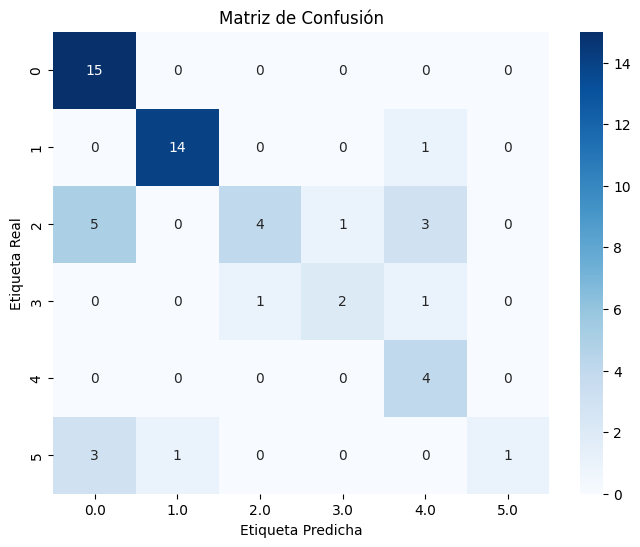

Precisión (Accuracy): 0.7142857142857143

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       0.93      0.93      0.93        15
           2       0.80      0.31      0.44        13
           3       0.67      0.50      0.57         4
           4       0.44      1.00      0.62         4
           5       1.00      0.20      0.33         5

    accuracy                           0.71        56
   macro avg       0.75      0.66      0.61        56
weighted avg       0.78      0.71      0.68        56



In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
 
# Matriz de Confusión
conf_matrix = confusion_matrix(a_cleaned['label_real'], a_cleaned['label_pred'])

# Precisión (Accuracy)
accuracy = accuracy_score(a_cleaned['label_real'], a_cleaned['label_pred'])

# Reporte completo de clasificación
report = classification_report(a_cleaned['label_real'], a_cleaned['label_pred'])

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in sorted(a_cleaned['label_pred'].unique())], 
            yticklabels=[str(i) for i in sorted(a_cleaned['label_real'].unique())])
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()


# Imprimir precisión y reporte
print("Precisión (Accuracy):", accuracy)
print("\nReporte de clasificación:")
print(report)

## PRUABA CON TODA LA BASE DE DATOS

In [18]:
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')
texto = df['textos']

modelos_dir = r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\modelos'
vectorizer_path = os.path.join(modelos_dir, 'vectorizer0_similitud.joblib')

# Procesar los textos
df_final = procesar_texto_y_clasificar(texto, vectorizer_path )

df_final = asignar_label_pred(df_final)


df_label_0 = df_final[df_final['label_pred'] == 0][['textos']]
df_label_non_0 = df_final[df_final['label_pred'] != 0]

#CARGAR VERTORIZERS Y MODELOS
primer_ensemble_model, vectorizer1, segundo_ensemble_model, vectorizer2 = cargar_modelos(modelos_dir)

df_label_0['label_pred'] = None

X = df_label_0['textos']

# Vectorización de texto usando TF-IDF
X_tfidf = vectorizer1.transform(X)

y_pred_main = primer_ensemble_model.predict(X_tfidf)
y_pred_main = pd.Series(y_pred_main)
y_pred_main.index = df_label_0.index

# Filtrar X_test_main y y_test_main en función de las predicciones del modelo principal
X_no_linea = X[y_pred_main == 0]

df_label_0.loc[y_pred_main.index, 'label_pred'] = y_pred_main

X_no_linea_tfidf = vectorizer2.transform(X_no_linea)

# Predicciones y evaluación del segundo modelo
y_pred_sub = segundo_ensemble_model.predict(X_no_linea_tfidf)
y_pred_sub = pd.Series(y_pred_sub)
y_pred_sub.index = X_no_linea.index
df_label_0.loc[y_pred_sub.index, 'label_pred'] = y_pred_sub

df_combined = pd.concat([df_label_0, df_label_non_0], axis=1)
df_combined = df_combined.groupby(df_combined.columns, axis=1).apply(lambda x: x.bfill(axis=1).iloc[:, 0])
df_combined = df_combined.sort_index()

# # df_combined.to_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\resultados_similitud.csv', index=False, encoding='utf-8-sig', sep=';')

a = pd.DataFrame({
    'label_pred': df_combined['label_pred'],
    'label_real': df['administracion']
})

C:\Users\lazkuenaru\AppData\Local\Temp\ipykernel_10112\418007091.py:45: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_combined = df_combined.groupby(df_combined.columns, axis=1).apply(lambda x: x.bfill(axis=1).iloc[:, 0])
C:\Users\lazkuenaru\AppData\Local\Temp\ipykernel_10112\418007091.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined = df_combined.groupby(df_combined.columns, axis=1).apply(lambda x: x.bfill(axis=1).iloc[:, 0])


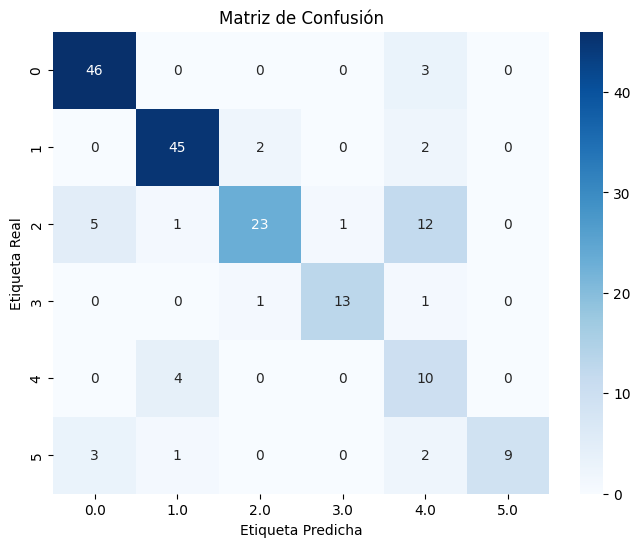

Precisión (Accuracy): 0.7934782608695652

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        49
           1       0.88      0.92      0.90        49
           2       0.88      0.55      0.68        42
           3       0.93      0.87      0.90        15
           4       0.33      0.71      0.45        14
           5       1.00      0.60      0.75        15

    accuracy                           0.79       184
   macro avg       0.81      0.76      0.76       184
weighted avg       0.85      0.79      0.80       184



In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
 
# Matriz de Confusión
conf_matrix = confusion_matrix(a['label_real'], a['label_pred'])

# Precisión (Accuracy)
accuracy = accuracy_score(a['label_real'], a['label_pred'])

# Reporte completo de clasificación
report = classification_report(a['label_real'], a['label_pred'])

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in sorted(a['label_pred'].unique())], 
            yticklabels=[str(i) for i in sorted(a['label_real'].unique())])
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()


# Imprimir precisión y reporte
print("Precisión (Accuracy):", accuracy)
print("\nReporte de clasificación:")
print(report)